## import

In [55]:
from src.config.config import Config
from src.db_writer.db import DB
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (12.8, 7.2)

## load data

### load from binance

In [57]:
from src.quarter_functions import get_delivery, get_quarter_time_left, get_quarter_symbol

In [58]:
# BTC_perp_bid_ask['timestamp'].min(), BTC_perp_bid_ask['timestamp'].max()
# (1661248680, 1684138560)

In [59]:
# config = Config()
# db = DB(config)

In [60]:
# def preprocess_data(data, symbol):
#     data_preprocessed = pd.DataFrame([[row[i] for i in [0,1,4,3,2,5,8]] for row in data], 
#                 columns=['timestamp', 'open', 'close', 'low', 'high', 'volume', 'trades'])
#     data_preprocessed['timestamp']/=1000
#     data_preprocessed.insert(column='symbol', loc=1, value=symbol)
#     return data_preprocessed


In [61]:
# def load_historical_perentrentual_data_batches(num_batches=1000):
#     all_time_data = []
#     endTime = (1684138560 + 30) * 1000
#     while endTime > 1661248680 * 1000:
#         all_time_data += config.binance_client.futures_klines(
#                     symbol = config.symbol, 
#                     interval = '1m', 
#                     limit = 1500, 
#                     endTime = endTime)
#         endTime -= 90000000
#     return preprocess_data(all_time_data, 'BTCUSDT')        


# def load_historical_quarterly_data_batches( num_batches=120):
#     final_data = pd.DataFrame()
#     endTime = (1684138560 + 30) * 1000
#     symbol = get_quarter_symbol(config.symbol,endTime/1000)
#     finished_trigger = False
#     quarter_data = []
#     while endTime > 1661248680 * 1000:
#         for i in range(num_batches):
#             data_1500 = config.binance_client.futures_klines(
#                             symbol = symbol, 
#                             interval = '1m', 
#                             limit = 1500, 
#                             endTime = endTime)
#             quarter_data += data_1500
#             endTime -= 90000000
            
#             if(len(data_1500) < 1500):
#                 finished_trigger = True
#                 break

#         if(finished_trigger == True):
#             final_data = pd.concat([final_data, preprocess_data(quarter_data, symbol)])
#             quarter_data = []
#             print(f"quarter {symbol} loading finished successfully")
#             symbol = get_quarter_symbol(config.symbol,endTime//1000)
#             endTime = get_delivery(endTime//1000)*1000
#             # print(f"{symbol} quarter endTime is {endTime}")
#             finished_trigger = False
#             print(f"quarter {symbol} loading")
#         else:
#             final_data = pd.concat([final_data, preprocess_data(quarter_data, symbol)])
#             print(symbol, end=' ')   
#     print(symbol)
#     return final_data 

In [62]:
# load_historical_perentrentual_data_batches().to_csv('data/load_historical_perentrentual_data_batches.csv')

In [63]:
# load_historical_quarterly_data_batches().to_csv('data/load_historical_quarterly_data_batches.csv')

### load rest

In [64]:
# BTC_current_quarter = pd.read_sql('SELECT * FROM `exchange data`.BTC_current_quarter;', con=db.con)
# BTC_current_quarter.to_csv('BTC_current_quarter.csv')

# BTC_perpetual = pd.read_sql('SELECT * FROM `exchange data`.BTC_perpetual;', con=db.con)
# BTC_perpetual.to_csv('BTC_perpetual.csv')

# BTC_cq_bid_ask = pd.read_sql('SELECT * FROM `exchange data`.BTC_cq_bid_ask;', con=db.con)
# BTC_cq_bid_ask.to_csv('data/BTC_cq_bid_ask.csv')

# BTC_perp_bid_ask = pd.read_sql('SELECT * FROM `exchange data`.BTC_perp_bid_ask;', con=db.con)
# BTC_perp_bid_ask.to_csv('data/BTC_perp_bid_ask.csv')

In [65]:
BTC_current_quarter = pd.read_csv('data/load_historical_quarterly_data_batches.csv', index_col=[0])
# BTC_current_quarter = pd.read_csv('data/BTC_current_quarter.csv', index_col=[0])
BTC_perpetual = pd.read_csv('data/load_historical_perentrentual_data_batches.csv', index_col=[0])
# BTC_perpetual = pd.read_csv('data/BTC_perpetual.csv', index_col=[0])
BTC_cq_bid_ask = pd.read_csv('data/BTC_cq_bid_ask.csv', index_col=[0])
BTC_perp_bid_ask = pd.read_csv('data/BTC_perp_bid_ask.csv', index_col=[0])

In [66]:
BTC_current_quarter = BTC_current_quarter\
            .sort_values(['timestamp', 'symbol'])\
            .drop_duplicates(subset=['timestamp'], keep='first')\
            .reset_index(drop=True)

BTC_perpetual.sort_values('timestamp', inplace=True)

## merge

In [67]:
candles = BTC_perpetual.merge(
            BTC_current_quarter, 
            on='timestamp', 
            how='left', 
            suffixes=['_perp', '_cq'])

order_book = BTC_perp_bid_ask.merge(
            BTC_cq_bid_ask, 
            on='timestamp', 
            suffixes=['_perp', '_cq'])

candles = candles[candles['timestamp'] >= order_book['timestamp'].min()]

df_total = candles.merge(
            order_book, 
            on='timestamp',
            how='left')


df_total['timestamp'] = df_total['timestamp'].astype(int)
df_total['time_left'] = df_total['timestamp'].apply(get_quarter_time_left)

In [68]:
# df_total = BTC_perpetual.merge(
#                 BTC_perp_bid_ask.drop('funding_rate', axis=1), on='timestamp')\
#         .merge(
#         BTC_current_quarter.merge(
#                 BTC_cq_bid_ask.drop('time_left', axis=1), on='timestamp'),
#         on = 'timestamp',
#         suffixes=['_perp', '_cq']
#         )

In [69]:
df_total.head()

,timestamp,symbol_perp,open_perp,close_perp,low_perp,high_perp,volume_perp,trades_perp,symbol_cq,open_cq,close_cq,low_cq,high_cq,volume_cq,trades_cq,bidPrice_perp,bidQty_perp,askPrice_perp,askQty_perp,funding_rate,bidPrice_cq,bidQty_cq,askPrice_cq,askQty_cq,time_left
0,1661248680,BTCUSDT,21476.3,21459.6,21451.0,21479.8,413.330,3596,BTCUSDT_220930,21511.1,21483.9,21483.9,21511.1,1.659,22,21476.2,8.013,21476.3,6.975,0.000011,21502.4,0.019,21508.0,0.071,3276120
1,1661248740,BTCUSDT,21459.7,21430.2,21430.2,21459.7,378.801,3206,BTCUSDT_220930,21493.2,21453.5,21453.5,21493.2,0.579,40,21459.1,3.420,21459.2,14.399,0.000012,21487.4,0.019,21493.3,0.050,3276060
2,1661248800,BTCUSDT,21430.3,21445.0,21414.1,21445.0,619.156,5519,BTCUSDT_220930,21459.9,21478.3,21440.6,21478.4,1.392,46,21432.6,0.820,21434.3,0.004,0.000012,21456.4,0.169,21462.8,0.071,3276000
3,1661248860,BTCUSDT,21445.0,21445.0,21430.0,21446.8,311.295,3116,BTCUSDT_220930,21476.7,21470.2,21460.0,21476.7,1.419,41,21444.9,25.023,21445.0,1.005,0.000011,21476.7,0.100,21478.3,0.054,3275940
4,1661248920,BTCUSDT,21445.0,21431.2,21430.0,21448.6,250.049,2848,BTCUSDT_220930,21479.4,21463.8,21460.4,21479.5,0.400,24,21444.9,17.361,21445.0,1.806,0.000010,21471.6,0.019,21476.5,0.121,3275880


### Funding rate restoration

## Fill missing

In [70]:
df_total = df_total.interpolate()

## EDA

In [71]:
df_total.head()

,timestamp,symbol_perp,open_perp,close_perp,low_perp,high_perp,volume_perp,trades_perp,symbol_cq,open_cq,close_cq,low_cq,high_cq,volume_cq,trades_cq,bidPrice_perp,bidQty_perp,askPrice_perp,askQty_perp,funding_rate,bidPrice_cq,bidQty_cq,askPrice_cq,askQty_cq,time_left
0,1661248680,BTCUSDT,21476.3,21459.6,21451.0,21479.8,413.330,3596,BTCUSDT_220930,21511.1,21483.9,21483.9,21511.1,1.659,22,21476.2,8.013,21476.3,6.975,0.000011,21502.4,0.019,21508.0,0.071,3276120
1,1661248740,BTCUSDT,21459.7,21430.2,21430.2,21459.7,378.801,3206,BTCUSDT_220930,21493.2,21453.5,21453.5,21493.2,0.579,40,21459.1,3.420,21459.2,14.399,0.000012,21487.4,0.019,21493.3,0.050,3276060
2,1661248800,BTCUSDT,21430.3,21445.0,21414.1,21445.0,619.156,5519,BTCUSDT_220930,21459.9,21478.3,21440.6,21478.4,1.392,46,21432.6,0.820,21434.3,0.004,0.000012,21456.4,0.169,21462.8,0.071,3276000
3,1661248860,BTCUSDT,21445.0,21445.0,21430.0,21446.8,311.295,3116,BTCUSDT_220930,21476.7,21470.2,21460.0,21476.7,1.419,41,21444.9,25.023,21445.0,1.005,0.000011,21476.7,0.100,21478.3,0.054,3275940
4,1661248920,BTCUSDT,21445.0,21431.2,21430.0,21448.6,250.049,2848,BTCUSDT_220930,21479.4,21463.8,21460.4,21479.5,0.400,24,21444.9,17.361,21445.0,1.806,0.000010,21471.6,0.019,21476.5,0.121,3275880


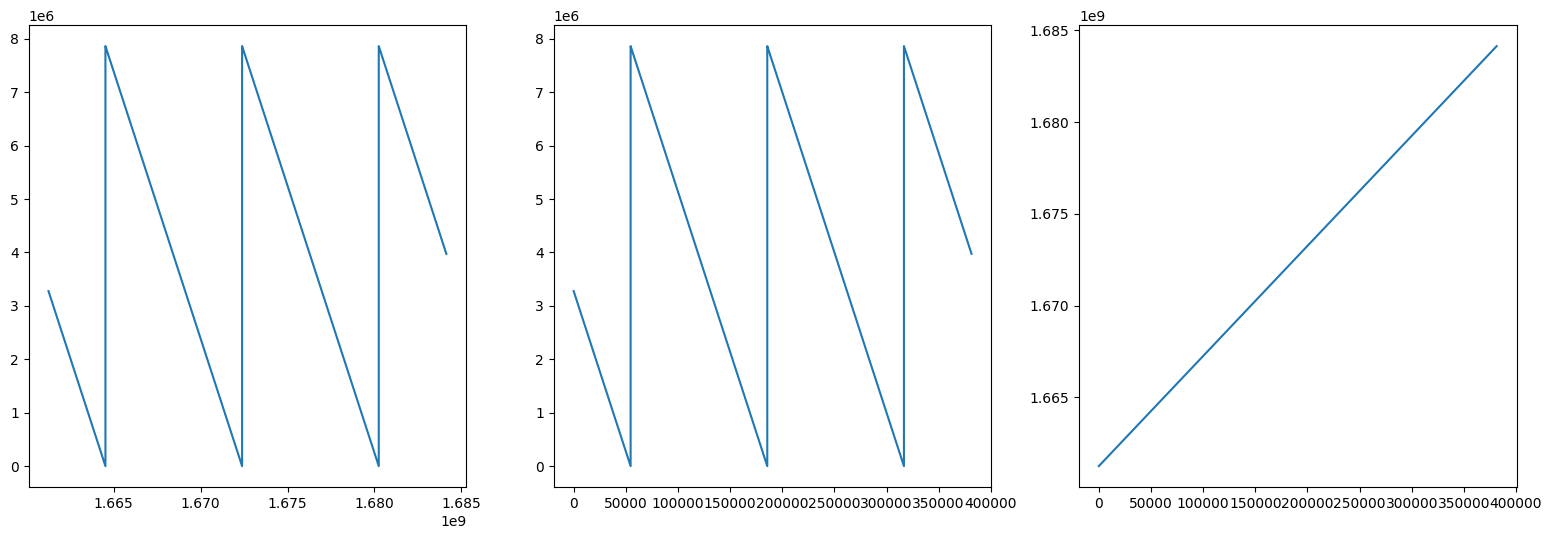

In [72]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(19.2, 6))
ax1.plot(df_total['timestamp'], df_total['time_left'])
ax2.plot(df_total['time_left'])
ax3.plot(df_total['timestamp'])
plt.show()

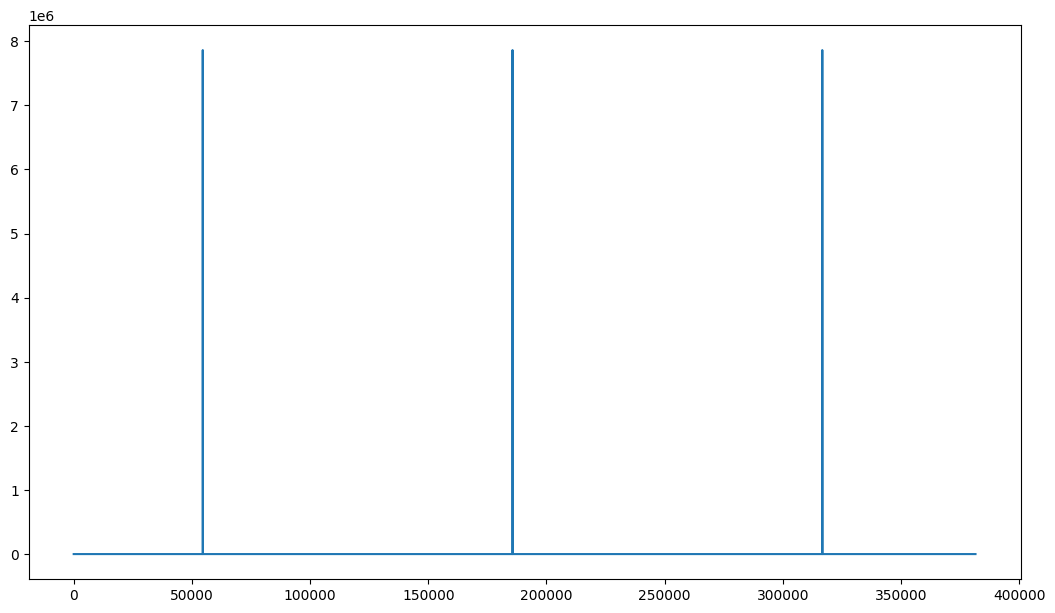

In [73]:
plt.figure(figsize=(12.8, 7.2))
temp = df_total['time_left'].diff()
plt.plot(temp)

(0.0, 32000.0)

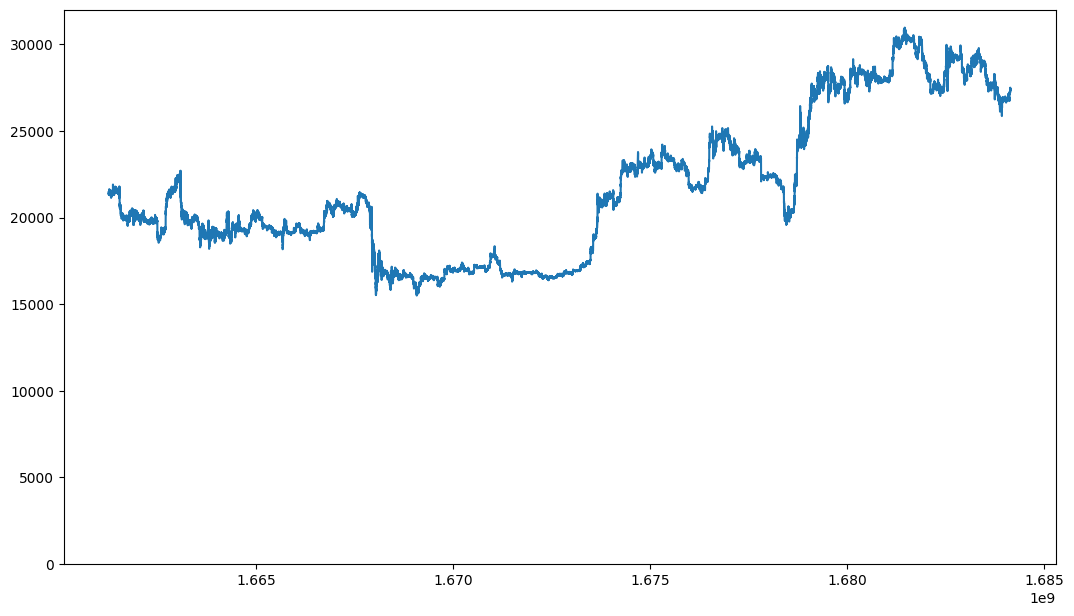

In [74]:
plt.figure(figsize = (12.8, 7.2))
plt.plot(df_total['timestamp'], df_total['open_perp'])
plt.ylim([0, 32000])
# plt.plot(df_total['timestamp'][-1000:], df_total['open_cq'][-1000:])
# plt.plot(df_total['timestamp'][-1000:], df_total['open_perp'][-1000:])
# plt.plot(df_total['timestamp'][-1000:], df_total['open_perp'][-1000:])

### other features overview

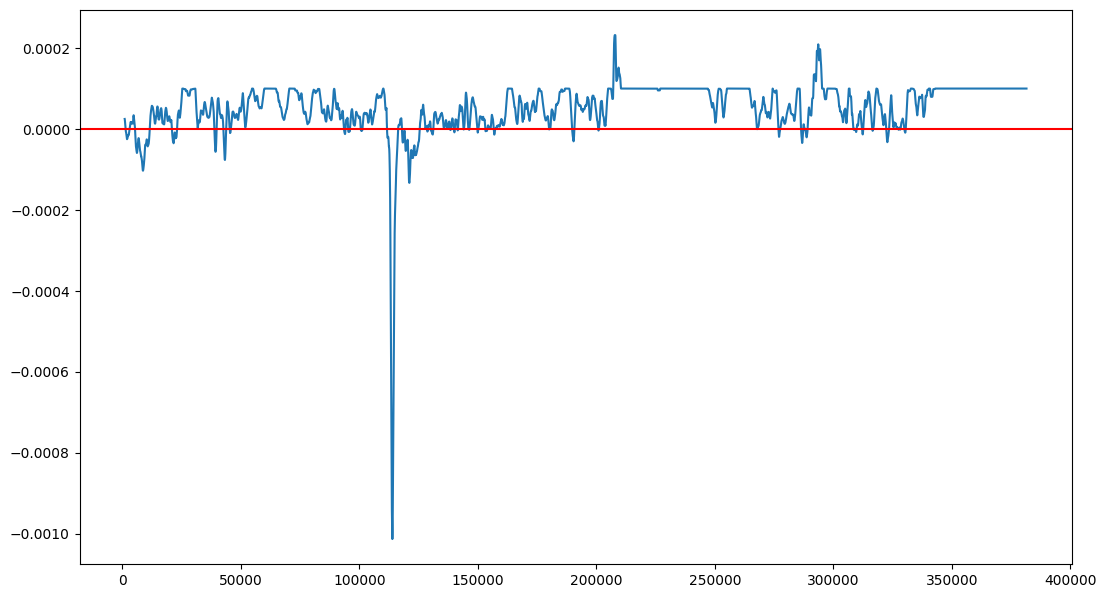

In [75]:
# plt.plot(df_total['funding_rate'])
plt.plot(df_total['funding_rate'].rolling(1000).mean())
plt.axhline(0, c = 'r')

In [76]:
df_total.head()

,timestamp,symbol_perp,open_perp,close_perp,low_perp,high_perp,volume_perp,trades_perp,symbol_cq,open_cq,close_cq,low_cq,high_cq,volume_cq,trades_cq,bidPrice_perp,bidQty_perp,askPrice_perp,askQty_perp,funding_rate,bidPrice_cq,bidQty_cq,askPrice_cq,askQty_cq,time_left
0,1661248680,BTCUSDT,21476.3,21459.6,21451.0,21479.8,413.330,3596,BTCUSDT_220930,21511.1,21483.9,21483.9,21511.1,1.659,22,21476.2,8.013,21476.3,6.975,0.000011,21502.4,0.019,21508.0,0.071,3276120
1,1661248740,BTCUSDT,21459.7,21430.2,21430.2,21459.7,378.801,3206,BTCUSDT_220930,21493.2,21453.5,21453.5,21493.2,0.579,40,21459.1,3.420,21459.2,14.399,0.000012,21487.4,0.019,21493.3,0.050,3276060
2,1661248800,BTCUSDT,21430.3,21445.0,21414.1,21445.0,619.156,5519,BTCUSDT_220930,21459.9,21478.3,21440.6,21478.4,1.392,46,21432.6,0.820,21434.3,0.004,0.000012,21456.4,0.169,21462.8,0.071,3276000
3,1661248860,BTCUSDT,21445.0,21445.0,21430.0,21446.8,311.295,3116,BTCUSDT_220930,21476.7,21470.2,21460.0,21476.7,1.419,41,21444.9,25.023,21445.0,1.005,0.000011,21476.7,0.100,21478.3,0.054,3275940
4,1661248920,BTCUSDT,21445.0,21431.2,21430.0,21448.6,250.049,2848,BTCUSDT_220930,21479.4,21463.8,21460.4,21479.5,0.400,24,21444.9,17.361,21445.0,1.806,0.000010,21471.6,0.019,21476.5,0.121,3275880


## razmetka

### mark extremas

In [77]:
df_total['diff'] = df_total['open_perp'].diff(1)
df_total['diff_shift1'] = df_total['diff'].shift(-1)
# if price didnt change from t-1, compare with t-2, t-3...
i = -1
print(i, (df_total['diff_shift1'] == 0).sum())
while ((df_total['diff_shift1'] == 0).sum()):
    i -= 1
    df_total.loc[df_total['diff_shift1'] == 0,'diff_shift1'] = \
            df_total['diff'].shift(i)[df_total['diff_shift1'] == 0]
    print(i, (df_total['diff_shift1'] == 0).sum())

df_total['is_extrema'] = (df_total['diff'] * df_total['diff_shift1'] < 0)

-1 8770
-2 1268
-3 401
-4 157
-5 69
-6 34
-7 16
-8 6
-9 2
-10 0


### prep

In [78]:
def plot_selected_extremas(df, column, window=200, color='red', figsize = (20,4)):
    plt.figure(figsize = figsize)
    plt.plot(df.loc[:window, 'open_perp'])
    plt.scatter(df.loc[df['is_extrema'] & (df.index < window)].index, 
                df.loc[df['is_extrema'] & (df.index < window), 'open_perp'], 
                c='yellow')
    plt.scatter(df.loc[df[column] & (df.index < window)].index, 
                df.loc[df[column] & (df.index < window), 'open_perp'], 
                c=color)
    plt.show()
    plt.close()

In [79]:
df_total['ismaxima'] = (df_total['diff_shift1'] < 0) & df_total['is_extrema']
df_total['isminima'] = (df_total['diff_shift1'] >= 0) & df_total['is_extrema']

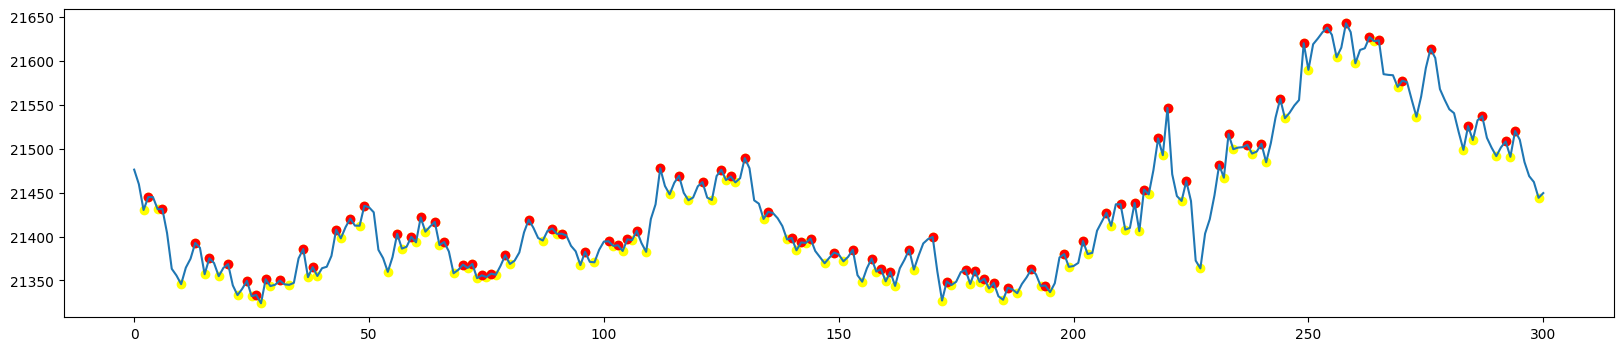

In [80]:
plot_selected_extremas(df_total, 'ismaxima', 300)

In [81]:
df_razmetka = df_total[['timestamp', 'open_perp', 'is_extrema', 'ismaxima', 'isminima']].copy()
df_razmetka.reset_index(inplace=True)
df_razmetka.head()

,index,timestamp,open_perp,is_extrema,ismaxima,isminima
0,0,1661248680,21476.3,False,False,False
1,1,1661248740,21459.7,False,False,False
2,2,1661248800,21430.3,True,False,True
3,3,1661248860,21445.0,True,True,False
4,4,1661248920,21445.0,False,False,False


profit = balance_start * (np.power(1-COMMISSION_RATE, 2) * (1 + LEVERAGE * (1 - close_price/open_price)) - 1)

In [82]:
COMMISSION_RATE = 0.0008
LEVERAGE = 5
balance = 10000

def calculate_profit(balance, open_price, close_price, commision=COMMISSION_RATE, leverage = LEVERAGE):
    return (balance *
            (np.power(1 - commision, 2) *
            (1 + leverage * abs(1 - close_price/open_price))
            - 1))
  
def get_balance(balance, open_price, close_price, commision=COMMISSION_RATE, leverage = LEVERAGE):
    return (balance * 
            (np.power(1 - commision, 2) *
            (1 + leverage * abs(1 - close_price/open_price))))

def get_balance_2contracts(balance, price0, price1, price2):
    balance1 = get_balance(balance, price0, price1)
    balance12 = get_balance(balance1, price1, price2)
    return balance12

def get_balance_3contracts(balance, price0, price1, price2, price3):
        balance1 = get_balance(balance, price0, price1)
        balance12 = get_balance(balance1, price1, price2)
        balance123 = get_balance(balance12, price2, price3)
        return balance123

In [83]:
min_profitability = 1.0075
min_prof_3contracts = min_profitability * 2 - 1

### step1

In [84]:
iterator = iter(df_razmetka.index[df_razmetka['is_extrema']])
#  skip first value because it wouldnt be an extrema
iterator.__next__()
(index_start, price_start) = df_razmetka.loc[iterator.__next__(), ['index', 'open_perp']]
extremas = [index_start]
try:
    while True: 
        index_first_contract, price_first_contract = df_razmetka.loc[iterator.__next__(), ['index', 'open_perp']]
        index_second_contract, price_second_contract = df_razmetka.loc[iterator.__next__(), ['index', 'open_perp']]
        index_third_contract, price_third_contract = df_razmetka.loc[iterator.__next__(), ['index', 'open_perp']]

        balance1 = get_balance(balance, price_start, price_first_contract)
        balance12 = get_balance(balance1, price_first_contract, price_second_contract)
        balance123 = get_balance(balance12, price_second_contract, price_third_contract)
        balance__3 = get_balance(balance, price_start, price_third_contract)


        max_balance = max(balance1, balance123/min_prof_3contracts, balance__3)

        if (max_balance > balance * min_profitability):
            if(max_balance == balance1):    
                extremas.append(index_first_contract)
                price_start = price_first_contract

            elif(max_balance == balance__3):
                iterator = iter(df_razmetka.index[df_razmetka['is_extrema'] & (df_razmetka.index>=index_third_contract)])

            elif(max_balance == balance123/min_prof_3contracts):
                extremas.append(index_first_contract)
                iterator = iter(df_razmetka.index[df_razmetka['is_extrema'] & (df_razmetka.index>=index_first_contract)])
                (index_start, price_start) = df_razmetka.loc[iterator.__next__(), ['index', 'open_perp']]
        else:
            pass
except StopIteration:
    pass

In [85]:
df_razmetka['extr1'] = np.where(df_razmetka.index.isin(extremas), True, False)

In [86]:
print(f"total extremas: {df_razmetka['is_extrema'].sum():>12,}")
print(f"extremas after step1: {df_razmetka['extr1'].sum():,}")

total extremas:      188,275
extremas after step1: 18,637


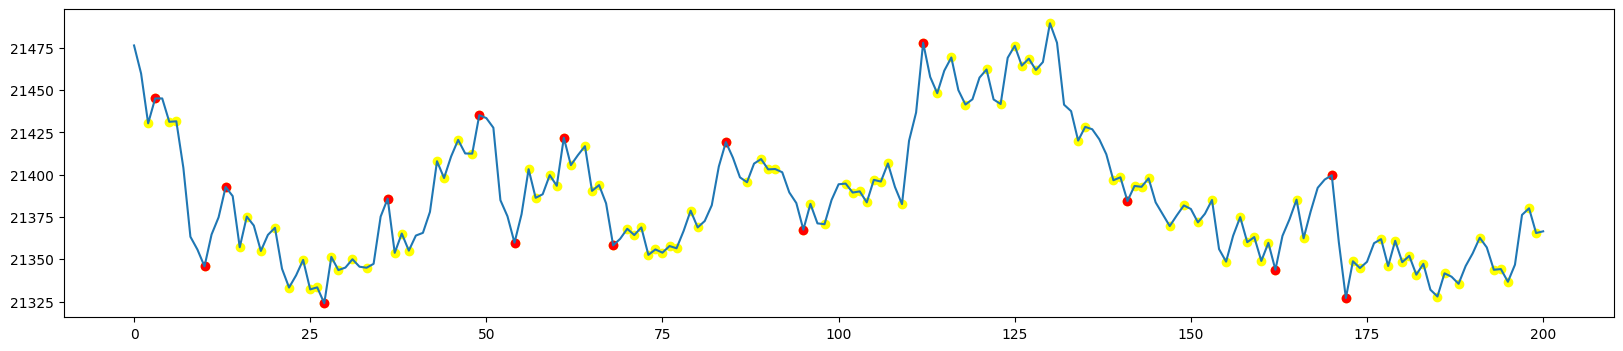

In [87]:
plot_selected_extremas(df_razmetka, 'extr1')

### step2

In [88]:
df_razmetka['extr2'] = df_razmetka['extr1'].copy()

all_extr = df_razmetka.loc[df_razmetka['is_extrema']].copy()
extr2 = df_razmetka.loc[df_razmetka['extr2']].reset_index(drop=True).copy()
non_extr2 = df_razmetka.loc[(~df_razmetka['extr2']) & df_razmetka['is_extrema']].copy()

extr2.head()

,index,timestamp,open_perp,is_extrema,ismaxima,isminima,extr1,extr2
0,3,1661248860,21445.0,True,True,False,True,True
1,10,1661249280,21345.8,True,False,True,True,True
2,13,1661249460,21392.7,True,True,False,True,True
3,27,1661250300,21324.0,True,False,True,True,True
4,36,1661250840,21385.8,True,True,False,True,True


In [89]:
start = 0
try:
    while True:
        left = extr2.loc[start, ['index', 'open_perp']]
        mid = extr2.loc[start+1, ['index', 'open_perp']]
        right = extr2.loc[start+2, ['index', 'open_perp']]
        
        extrema_range = all_extr.loc[left['index']:right['index']]

        if left['open_perp'] > mid['open_perp']:
            index_extrema = extrema_range['open_perp'].idxmin()
        elif left['open_perp'] < mid['open_perp']:
            index_extrema = extrema_range['open_perp'].idxmax()
        else:
            extr2.drop(extr2.index[extr2['index'] == mid['index']])
            continue

        extrema_range = all_extr.loc[left['index']:right['index']]
        if index_extrema == mid['index']:
            start += 1
            continue
        elif index_extrema == right['index']:
            extr2 = extr2.drop(start+1).reset_index(drop=True)
            continue
        else:
            # print(f"replace extrema {mid['index']} on {index_extrema}")
            extr2.loc[start+1] = extrema_range.loc[index_extrema]
            start += 1
            continue
except:
    pass

In [90]:
df_razmetka['extr2'] = np.where(df_razmetka.index.isin(extr2['index']), True, False)
df_razmetka.to_csv('df_razmetka_after_step2.csv')

In [91]:
print(f"total extremas: {df_razmetka['is_extrema'].sum():>12,}")
print(f"extremas after step1: {df_razmetka['extr1'].sum():,}")
print(f"extremas after step2: {df_razmetka['extr2'].sum():,}")

total extremas:      188,275
extremas after step1: 18,637
extremas after step2: 16,040


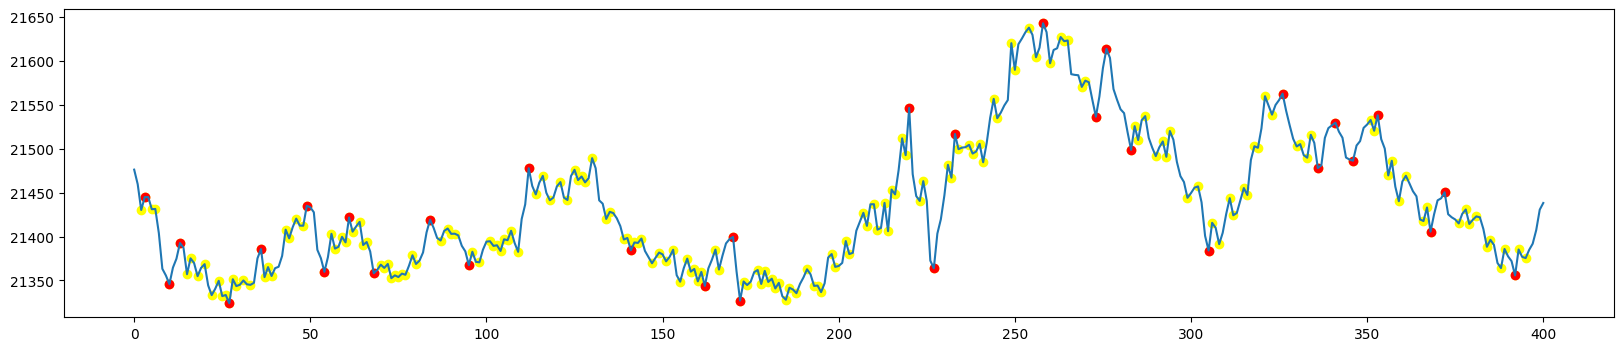

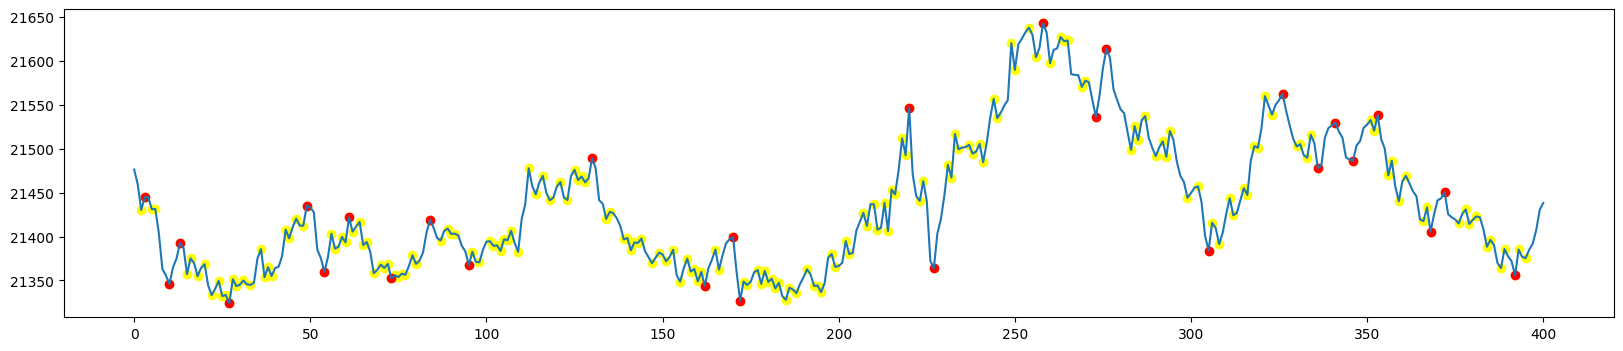

In [92]:
plot_selected_extremas(df_razmetka, 'extr1', 400)
plot_selected_extremas(df_razmetka, 'extr2', 400)

### step 3

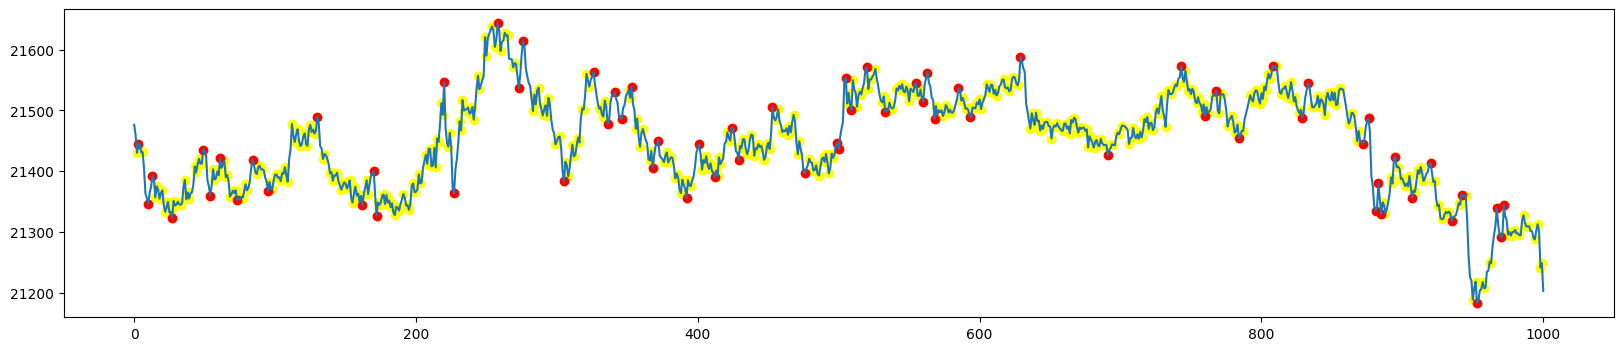

,index,timestamp,open_perp,is_extrema,ismaxima,isminima,extr1,extr2
3,3,1661248860,21445.0,True,True,False,True,True
10,10,1661249280,21345.8,True,False,True,True,True
13,13,1661249460,21392.7,True,True,False,True,True
27,27,1661250300,21324.0,True,False,True,True,True
49,49,1661251620,21435.1,True,True,False,True,True


In [93]:
plot_selected_extremas(df_razmetka, 'extr2', 1000, figsize=(20,4))
df_razmetka.loc[df_razmetka['extr2']].head()

In [98]:
from IPython.display import clear_output

In [103]:
### доделать, после дропа контрактов надо перезапускать

def price(idx):
    return df_razmetka.loc[idx, 'open_perp']
    
df_razmetka['extr3'] = df_razmetka['extr2']
start = 0
while True:
    extremas_todrop = []
    for contract0, contract1, contract2, contract3 in zip(
                            df_razmetka.loc[df_razmetka['extr3'], 'index'].loc[start:].iloc[:-3], 
                            df_razmetka.loc[df_razmetka['extr3'], 'index'].loc[start:].shift(-1).iloc[:-3], 
                            df_razmetka.loc[df_razmetka['extr3'], 'index'].loc[start:].shift(-2).iloc[:-3], 
                            df_razmetka.loc[df_razmetka['extr3'], 'index'].loc[start:].shift(-3).iloc[:-3]):
        # print(contract0, contract1, contract2, contract3)
        # print(price(contract0), price(contract1), price(contract2), price(contract3))

        balance1 = get_balance(1, 
                    price(contract0), 
                    price(contract3))
        balance3 = get_balance_3contracts(1, 
                    price(contract0), 
                    price(contract1), 
                    price(contract2), 
                    price(contract3))
        if (balance1*min_prof_3contracts >= balance3):
            df_razmetka.loc[[contract1, contract2], 'extr3'] = False
            extremas_todrop += [contract1, contract2]
            clear_output(wait=True)
            print(extremas_todrop)
            start = contract3
            break
    if(len(extremas_todrop) == 0):

        break

[381303.0, 381307.0]


In [95]:
# df_razmetka['extr3'] = df_razmetka['extr2']
# df_razmetka.loc[extremas_todrop, 'extr3'] = False

In [104]:
print(f"total extremas: {df_razmetka['is_extrema'].sum():>12,}")
print(f"extremas after step1: {df_razmetka['extr1'].sum():,}")
print(f"extremas after step2: {df_razmetka['extr2'].sum():,}")
print(f"extremas after step3: {df_razmetka['extr3'].sum():,}")

total extremas:      188,275
extremas after step1: 18,637
extremas after step2: 16,040
extremas after step3: 15,096


In [42]:
print(f"total extremas: {df_razmetka['is_extrema'].sum():>12,}")
print(f"extremas after step1: {df_razmetka['extr1'].sum():,}")
print(f"extremas after step2: {df_razmetka['extr2'].sum():,}")
print(f"extremas after step3: {df_razmetka['extr3'].sum():,}")

total extremas:      188,275
extremas after step1: 18,637
extremas after step2: 16,040
extremas after step3: 15,054


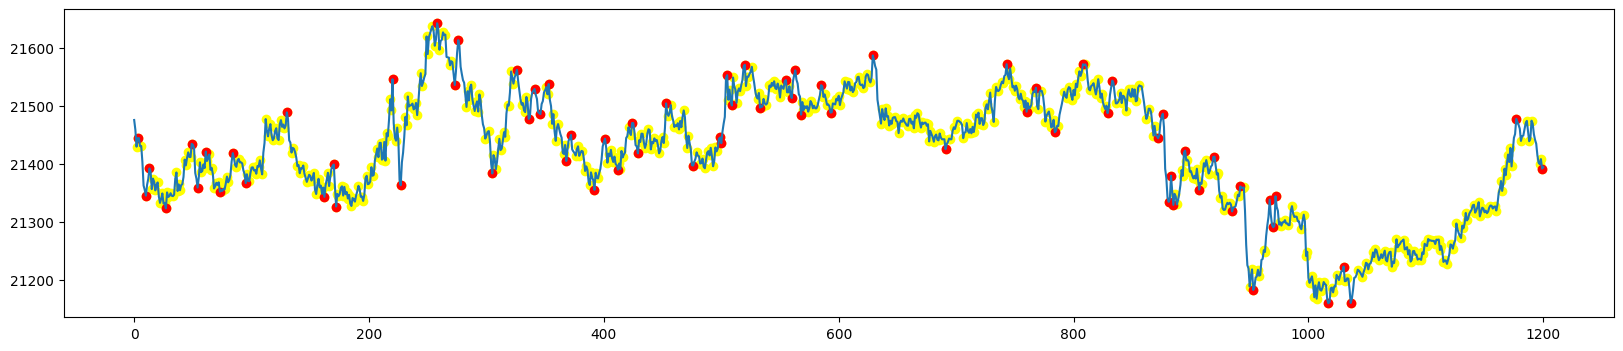

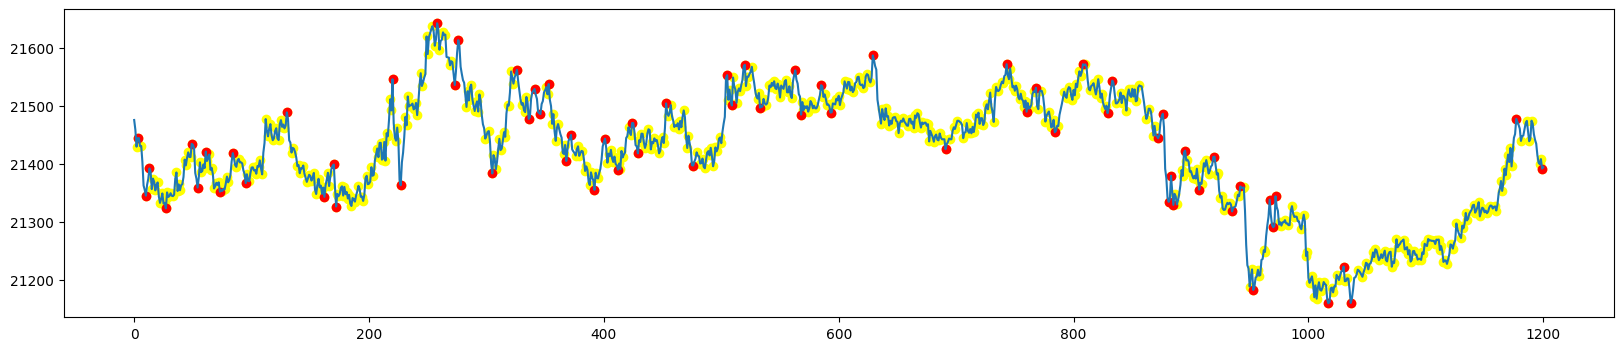

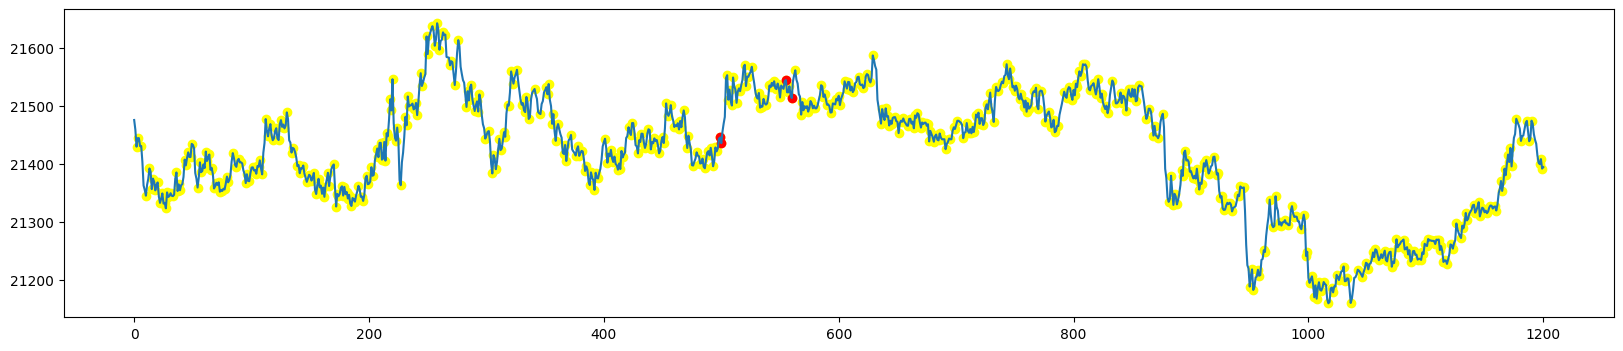

In [43]:
plot_selected_extremas(df_razmetka, 'extr2', 1200, figsize=(20,4))
plot_selected_extremas(df_razmetka, 'extr3', 1200, figsize=(20,4))

df_razmetka['temp'] = df_razmetka['extr2'] & (~df_razmetka['extr3'])
plot_selected_extremas(df_razmetka, 'temp', 1200, figsize=(20,4))
df_razmetka.drop('temp', axis=1, inplace=True)

### step 4

In [44]:
from tqdm import tqdm

In [45]:
# def step3():
#     new_extremas3 = []
#     for start, end in tqdm(zip(df_razmetka.loc[df_razmetka['extr3'], 'index'].iloc[:-1], df_razmetka.loc[df_razmetka['extr3'], 'index'].shift(-1))):
#         # print(df_razmetka.loc[start+1:end-1].loc[df_razmetka['isminima']].index)
#         # print(df_razmetka.loc[start+1:end-1].loc[df_razmetka['ismaxima']].index)

#         if (df_razmetka.loc[start, 'open_perp'] > df_razmetka.loc[end, 'open_perp']):
#             order_short_long = ('isminima', 'ismaxima')
#         elif (df_razmetka.loc[start, 'open_perp'] > df_razmetka.loc[end, 'open_perp']):
#             order_short_long = ('ismaxima', 'isminima')

#         profitable_combos = {}
#         for first_contract in df_razmetka.loc[start+1:end-1].loc[df_razmetka[order_short_long[0]]].index:
#             for second_contract in df_razmetka.loc[first_contract+1:end-1].loc[df_razmetka[order_short_long[1]]].index:
#                 # print(first_contract, second_contract)
#                 extr2_balance = get_balance(1, df_razmetka.loc[start, 'open_perp'], df_razmetka.loc[end, 'open_perp'])

#                 extr3_1 = get_balance(1, df_razmetka.loc[start, 'open_perp'], df_razmetka.loc[first_contract, 'open_perp'])
#                 extr3_2 = get_balance(extr3_1, df_razmetka.loc[first_contract, 'open_perp'], df_razmetka.loc[second_contract, 'open_perp'])
#                 extr3_balance = get_balance(extr3_2, df_razmetka.loc[second_contract, 'open_perp'], df_razmetka.loc[end, 'open_perp'])

#                 if(extr3_balance > extr2_balance * min_prof_3contracts):
#                     profitable_combos.update({(first_contract, second_contract) : extr3_balance})
#         if(len(profitable_combos) > 0):
#             new_extremas3.append(max(profitable_combos, key=profitable_combos.get))
#             # print('interval: ',start, end)
#             # print(profitable_combos)
#             # print('best: ',max(profitable_combos, key=profitable_combos.get))
#             # print()
#     return(new_extremas3)

In [46]:
def price(df, idx):
    return df.loc[idx, 'open_perp']

def step4(df_raw, existing_extrema_col):
    df = df_raw.copy()
    df['extr4'] = df[existing_extrema_col]
    while(True):
        new_extremas3 = []
        for start, end in tqdm(zip(
                                    df.loc[df['extr4'], 'index'].iloc[:-1], 
                                    df.loc[df['extr4'], 'index'].shift(-1))):
            
            if (price(df, start) > price(df, end)):
                order_short_long = ('isminima', 'ismaxima')
            elif (price(df, start) > price(df, end)):
                order_short_long = ('ismaxima', 'isminima')

            profitable_combos = {}
            for first_contract in df.loc[start+1:end-1].loc[df[order_short_long[0]]].index:
                for second_contract in df.loc[first_contract+1:end-1].loc[df[order_short_long[1]]].index:
                    extr2_balance = get_balance(1, 
                                                price(df, start), 
                                                price(df, end))
                    extr3_balance = get_balance_3contracts(1, 
                                                price(df, start),
                                                price(df, first_contract),
                                                price(df, second_contract),
                                                price(df, end))
                    
                    if(extr3_balance > extr2_balance * min_prof_3contracts):
                        profitable_combos.update({(first_contract, second_contract) : extr3_balance})
            if(len(profitable_combos) > 0):
                new_extremas3.append(max(profitable_combos, key=profitable_combos.get))

        
        print(f"extremas before: {df['extr4'].sum()}")
        df.loc[pd.Series(new_extremas3).explode().values, 'extr4'] = True
        print(f"extremas after:  {df['extr4'].sum()}")
        
        if (len(new_extremas3) == 0):
            return df

In [47]:
df_razmetka = step4(df_razmetka, 'extr3')

15053it [02:34, 97.14it/s] 


extremas before: 15054
extremas after:  16470


16469it [02:07, 129.31it/s]


extremas before: 16470
extremas after:  16752


16751it [01:58, 141.45it/s]


extremas before: 16752
extremas after:  16780


16779it [02:02, 137.07it/s]


extremas before: 16780
extremas after:  16782


16781it [02:00, 139.01it/s]

extremas before: 16782
extremas after:  16782



c:\Coding\Anaconda\envs\diploma_binance\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [48]:
print(f"total extremas: {df_razmetka['is_extrema'].sum():>12,}")
print(f"extremas after step1: {df_razmetka['extr1'].sum():,}")
print(f"extremas after step2: {df_razmetka['extr2'].sum():,}")
print(f"extremas after step3: {df_razmetka['extr3'].sum():,}")
print(f"extremas after step4: {df_razmetka['extr4'].sum():,}")

total extremas:      188,275
extremas after step1: 18,637
extremas after step2: 16,040
extremas after step3: 15,054
extremas after step4: 16,782


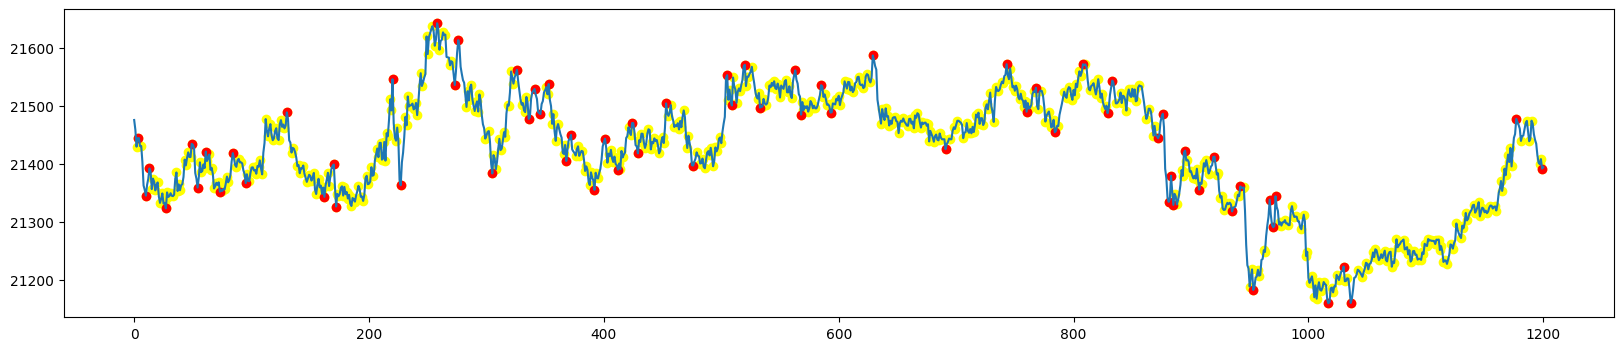

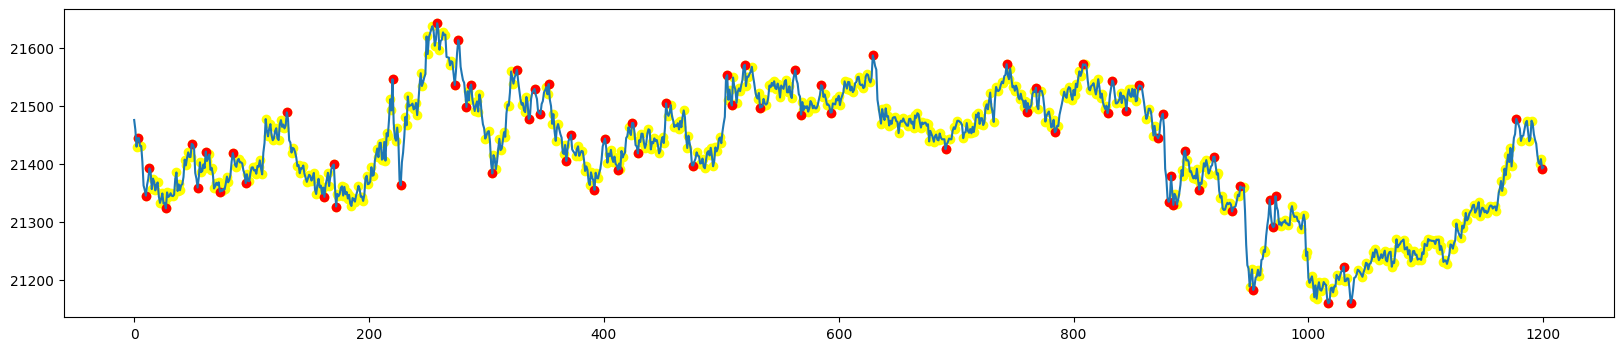

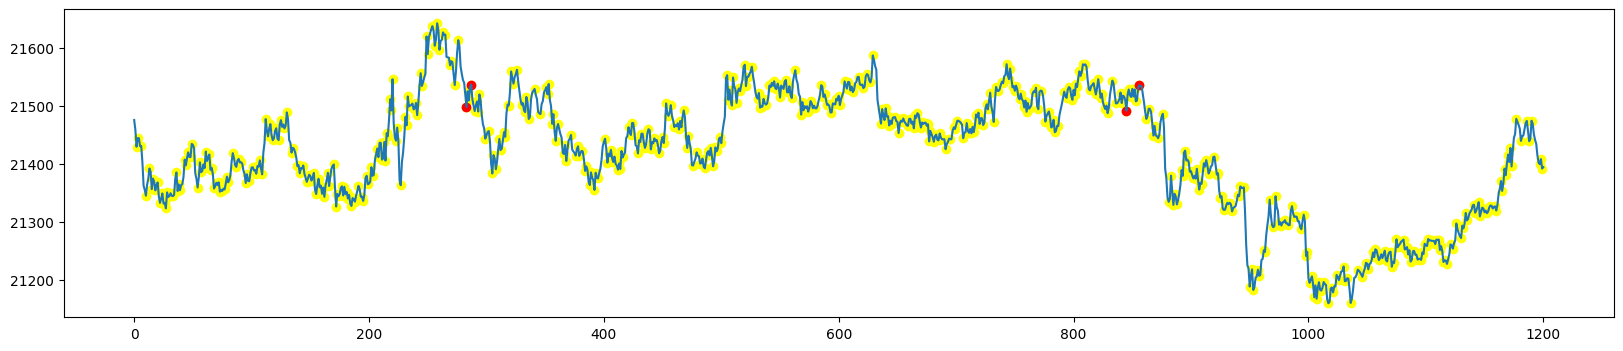

In [50]:
plot_selected_extremas(df_razmetka, 'extr3', 1200, figsize=(20,4))
plot_selected_extremas(df_razmetka, 'extr4', 1200, figsize=(20,4))

df_razmetka['temp'] = df_razmetka['extr4'] & (~df_razmetka['extr3'])
plot_selected_extremas(df_razmetka, 'temp', 1200, figsize=(20,4))
df_razmetka.drop('temp', axis=1, inplace=True)

## punish 30min+

In [53]:
def price(idx):
    return df_razmetka.loc[idx, 'open_perp']
    
    
extremas_todrop = []
for contract0, contract1, contract2, contract3 in zip(
                        df_razmetka.loc[df_razmetka['extr4'], 'index'].iloc[:-3], 
                        df_razmetka.loc[df_razmetka['extr4'], 'index'].shift(-1).iloc[:-3], 
                        df_razmetka.loc[df_razmetka['extr4'], 'index'].shift(-2).iloc[:-3], 
                        df_razmetka.loc[df_razmetka['extr4'], 'index'].shift(-3).iloc[:-3]):
    # print(contract0, contract1, contract2, contract3)
    # print(price(contract0), price(contract1), price(contract2), price(contract3))

    balance1 = get_balance(1, 
                price(contract0), 
                price(contract3))
    balance3 = get_balance_3contracts(1, 
                price(contract0), 
                price(contract1), 
                price(contract2), 
                price(contract3))
    if (balance1*min_prof_3contracts >= balance3):
        extremas_todrop += [contract1, contract2]

In [54]:
extremas_todrop

[9968.0,
 9974.0,
 17542.0,
 17568.0,
 39279.0,
 39284.0,
 47122.0,
 47123.0,
 69110.0,
 69114.0,
 106008.0,
 106016.0,
 116903.0,
 116911.0,
 123915.0,
 123929.0,
 151358.0,
 151375.0,
 164062.0,
 164090.0,
 176349.0,
 176399.0,
 176431.0,
 176512.0,
 196454.0,
 196457.0,
 201511.0,
 201522.0,
 205536.0,
 205550.0,
 210976.0,
 210998.0,
 213294.0,
 213302.0,
 223807.0,
 223811.0,
 231712.0,
 231719.0,
 242273.0,
 242288.0,
 244067.0,
 244072.0,
 248605.0,
 248617.0,
 272154.0,
 272169.0,
 281677.0,
 281694.0,
 303729.0,
 303732.0,
 307594.0,
 307598.0,
 353115.0,
 353119.0,
 372227.0,
 372230.0]

In [51]:
df_razmetka.head()

,index,timestamp,open_perp,is_extrema,ismaxima,isminima,extr1,extr2,extr3,extr4
0,0,1661248680,21476.3,False,False,False,False,False,False,False
1,1,1661248740,21459.7,False,False,False,False,False,False,False
2,2,1661248800,21430.3,True,False,True,False,False,False,False
3,3,1661248860,21445.0,True,True,False,True,True,True,True
4,4,1661248920,21445.0,False,False,False,False,False,False,False


In [52]:
# df_razmetka.to_csv('df_razmetka_after_step4.csv')

In [ ]:
df_razmetka.loc[df_razmetka['extr2'], 'timestamp'].diff().quantile(0.885)

In [ ]:
df_razmetka.loc[df_razmetka['extr2']].head()

In [ ]:
extremas = df_razmetka.loc[df_razmetka['extr2']].copy()

In [ ]:
extremas['diff'] = extremas['timestamp'].diff() 

In [ ]:
extremas.head()

In [ ]:
extremas.loc[extremas['diff'] > 3000]

In [ ]:
(df_razmetka.loc[df_razmetka['extr2'], 'timestamp'].diff() > 3000).value_counts()

In [ ]:
60 * 30

## Initial model

### final df prep

In [ ]:
df_total.to_csv('data/df_total.csv')
df_razmetka.to_csv('data/df_razmetka.csv')

df_total = pd.read_csv('data/df_total.csv', index_col=[0])
df_razmetka = pd.read_csv('data/df_razmetka.csv', index_col=[0])

In [ ]:
df_fin = df_total.copy()

In [ ]:
df_fin['extr2'] = df_razmetka['extr2']

In [ ]:
df_fin.drop(columns=['symbol_perp','time_diff', 'diff', 'diff_shift1', 'is_extrema'], inplace=True)

In [ ]:
df_fin.head()

In [ ]:
df_fin.groupby('symbol_cq').agg({'timestamp':['min', 'max']}).apply(lambda x: pd.to_datetime(x, unit='s'))

Lets imagine our range of opening contract lays between 

(high + max(open, close))/2

and

(low + min(open, close))/2

In [ ]:
df_fin['low_border'] = (df_fin['low_perp'] + df_fin[['open_perp', 'close_perp']].min(axis=1)) / 2
df_fin['up_border'] = (df_fin['high_perp'] + df_fin[['open_perp', 'close_perp']].max(axis=1)) / 2

In [ ]:
df_fin.head()

In [ ]:
df_fin.loc[df_fin['extr2'] & df_fin['ismaxima'], 'target'] = df_fin.loc[df_fin['extr2'] & df_fin['ismaxima'], 'up_border']
df_fin.loc[df_fin['extr2'] & df_fin['isminima'], 'target'] = df_fin.loc[df_fin['extr2'] & df_fin['isminima'], 'low_border']

In [ ]:
df_fin = df_fin.fillna(method='bfill').dropna()

In [ ]:
df_fin.head()

In [ ]:
X = df_fin.drop(columns= ['timestamp', 'symbol_cq', 'ismaxima', 'isminima', 'extr2', 'low_border', 'up_border', 'target'])
y = df_fin['target']

In [ ]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)
y_scaled = StandardScaler().fit_transform(y.values.reshape(-1,1))

In [ ]:
X_scaled
y_scaled

## Simple Keras LSTM model

## Archive

In [ ]:
# # for left, mid, right in zip(new_extremas[:-2], new_extremas[1:-1], new_extremas[2:]):
# non_extremas = pd.Series(list(set(df_total.index[df_total['is_extrema']]) - set(extremas) - set([2])))
# non_extremas.head()

# new_extremas = extremas.copy()
# start = 0
# while True:
#     new_extremas.reset_index(inplace=True, drop=True)
#     # print(new_extremas.head())
#     left, mid, right = new_extremas.index[start], new_extremas.index[start+1], new_extremas.index[start+2]
#     print(f"{start} - {new_extremas[left]:>3} ({df_total.loc[left, 'open_perp']}) {new_extremas[mid]} ({df_total.loc[mid, 'open_perp']}) {new_extremas[right]} ({df_total.loc[right, 'open_perp']})", end = '   ')
#     points_inbetween = non_extremas[(non_extremas > left) & (non_extremas < right)]
#     all_points = pd.concat([points_inbetween, pd.Series([left, mid, right])])
#     if (df_total.loc[new_extremas[left], 'open_perp'] > df_total.loc[new_extremas[mid], 'open_perp']):
#         print('min')
#         new_minima = df_total.loc[all_points, 'open_perp'].idxmin()
#         if new_minima == new_extremas[mid]:
#             start += 1
#             continue
#         elif new_minima == new_extremas[right]:
#             new_extremas.pop(new_extremas[start+1])
#             continue
#         else:
#             new_extremas[start+1] = new_minima
#             start += 1
#             continue
#     elif (df_total.loc[new_extremas[left], 'open_perp'] < df_total.loc[new_extremas[mid], 'open_perp']):
#         print('max')
#         new_maxima = df_total.loc[all_points, 'open_perp'].idxmax()
#         if new_maxima == new_extremas[mid]:
#             start += 1
#             continue
#         elif new_maxima == new_extremas[right]:
#             new_extremas.pop(new_extremas[start+1])
#             continue
#         else:
#             new_extremas[start+1] = new_maxima
#             start += 1
#             continue
#     else:
#         print('drop')
#         new_extremas.pop(new_extremas.index[mid])
#         continue
    
        